# Import libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import functools
import importlib
import cmocean
import h5py

from scipy.sparse.linalg import gmres, lgmres
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import mpl_toolkits.axes_grid1
from tqdm import tqdm_notebook as tqdm

import spm.utils as utils
import spm.spm as spm
def reload():
    importlib.reload(utils)
    importlib.reload(spm)

-----
# Set up parameters

In [263]:
Np = 6
dimention = 2
epsilon_f = 1
epsilon_p = 10

sys  = spm.SPM2D({'grid':{'powers':[Np,Np], 'dx':0.5},\
                  'particle':{'a':5, 'a_xi':2, 'mass_ratio':1.1},\
                  'fluid':{'rho':1.0, 'mu':1.0}})
ze = np.array([1,-1])[...,None]
gamma = np.ones(2)[...,None]
kbT = 1

dt      =  np.min([1 / (sys.fluid.nu*sys.grid.maxK2()) , 1 / (kbT*gamma[0]*sys.grid.maxK2())])
phihL   = utils.etdPhi(-sys.fluid.nu*sys.grid.K2*dt)
phir = (lambda x : utils.phiGauss(x, sys.particle.radius, sys.particle.xi, sys.grid.dx))
phi_sine = (lambda x : utils.phiSine(x, sys.particle.radius, sys.particle.xi))

X, Y  = sys.grid.X[0][:,:], sys.grid.X[1][:,:]
x = X[:,0]
y = Y[0,:]

In [264]:
# functions for graph

def set_colorbar(ax, pmesh):
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = fig.colorbar(pmesh, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    
def set_transparency(fig, ax):
    fig.patch.set_facecolor("white")  
    fig.patch.set_alpha(0.0)
    ax.patch.set_facecolor("white") 
    ax.patch.set_alpha(0.0)
    
def put_circle(da, x, y, **kwargs):
    circle = patches.Wedge( (x, y), sys.particle.radius+da, 0, 360, linewidth = 2.0, fill=False, alpha= 1, **kwargs)
    ax.add_patch(circle)
    
def add_cbar(fig, ax, im, label="hoge"):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    if label != "hoge":
        cbar.set_label(label, size=26)
        
def set_here(fig, ax):
    ax.set_xlim(0,sys.grid.length[0]-sys.grid.dx)
    ax.set_ylim(0,sys.grid.length[1]-sys.grid.dx)
    ax.set_xlabel("x", fontsize=30)
    ax.set_ylabel("y", fontsize=30)
    ax.xaxis.set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    fig.patch.set_facecolor("w")  
    fig.patch.set_alpha(0)
    ax.patch.set_facecolor("w") 
    ax.patch.set_alpha(0)
    ax.set_aspect('equal')

-----
# Define permittivity field 
$\varepsilon = \varepsilon_p\phi + \varepsilon_f(1-\phi)$

In [265]:
R = np.ones((1,2))*sys.grid.length/2
phi = sys.makePhi(phir, R)

epsilon = epsilon_p*phi + epsilon_f*(1-phi) 

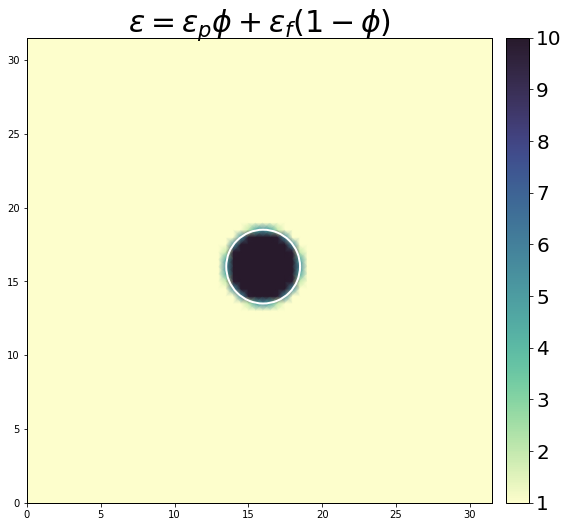

In [266]:
plt.clf()
fig, ax = plt.subplots(figsize=(9,9))
pmesh = ax.pcolormesh(sys.grid.X[0][:,:], sys.grid.X[1][:,:], epsilon[:,:], \
                      cmap=cmocean.cm.deep, shading='gouraud')
set_colorbar(ax, pmesh)
set_transparency(fig, ax)
put_circle(0, R[0,0], R[0,1], color='w')
ax.set_aspect("equal")
ax.set_title(r"$\varepsilon = \varepsilon_p\phi + \varepsilon_f(1-\phi)$", fontsize=30)
plt.show()

In [267]:
# get differential of permittivity

grad = lambda a : sys.ifftu(1j*np.array(sys.grid.K)*a[None,...])

def grad_field(a, phi):
    grad = lambda a : sys.ifftu(1j*np.array(sys.grid.K)*a[None,...])
    grad_a = grad(sys.ffta(a))
    iid0 = phi==0
    iid1 = phi==1
    for i in range(2):
        grad_a[i][iid0] = 0
        grad_a[i][iid1] = 0
    return grad_a

grad_ep = grad_field(epsilon, phi)

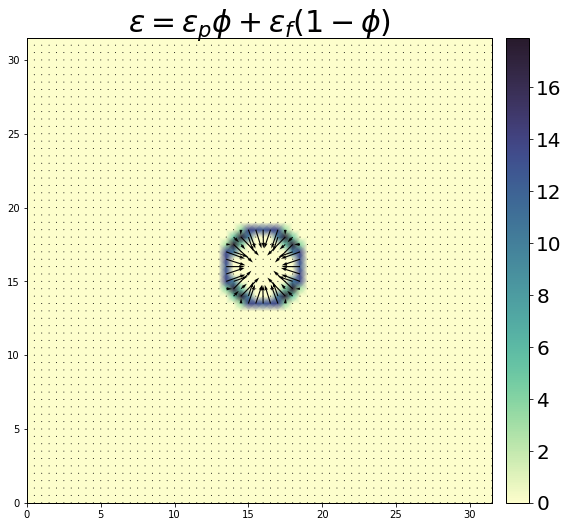

In [268]:
plt.clf()
fig, ax = plt.subplots(figsize=(9,9))
pmesh = ax.pcolormesh(sys.grid.X[0][:,:], sys.grid.X[1][:,:], np.linalg.norm(grad_ep, axis=0)[:,:], \
                      cmap=cmocean.cm.deep, shading='gouraud')
ax.quiver(sys.grid.X[0][:,:],sys.grid.X[1][:,:], grad_ep[0,:,:], grad_ep[1,:,:], units="xy", scale=10)
set_colorbar(ax, pmesh)
set_transparency(fig, ax)

#ax.set_xlim(10,22)
#ax.set_ylim(10,22)
ax.set_aspect("equal")
ax.set_title(r"$\varepsilon = \varepsilon_p\phi + \varepsilon_f(1-\phi)$", fontsize=30)
plt.show()

In [269]:
def makeRhoe(phi, c, ze):
    return (1 - phi)*functools.reduce(lambda a, b: a + b, map(lambda zei,ci : zei*ci, ze, c))

ze = np.array([+1,-1])
species = 2
c = np.ones(species*sys.grid.ns[0]*sys.grid.ns[1]).reshape([species,sys.grid.ns[0],sys.grid.ns[1]])
rho_e = makeRhoe(phi, c, ze)
gamma = np.ones(2)[...,None]
kbT = 1

-----
# Main

In [270]:
class gmres_counter(object):
        def __init__(self, disp=True):
            self._disp = disp
            self.niter = 0
        def __call__(self, rk=None):
            self.niter += 1
            if self._disp:
                print('iter %3i\t min = %.3e\t max = %.3e' % (self.niter, np.min(np.abs(A*rk-b)), np.max(np.abs(A*rk-b))))

def initialize_func(coef_E, eps_f, eps_p, noise=False):
    N_     = int(sys.grid.ns[0]) 
    R_     = np.ones((1,2))*sys.grid.length/2
    if noise:
        R_+= np.random.rand(2)[None,...]*sys.grid.dx
    phi_   = sys.makePhi(phi_sine, R_)
    eps_   = eps_p*phi_ + eps_f*(1-phi_) 
    deps_  = sys.ifftu(1j*sys.grid.K*sys.grid.shiftK()*sys.ffta(eps_))
    NN_    = np.prod(eps_.shape)
    rho_e_ = np.zeros_like(eps_)
    E_ex_  = np.stack([np.ones_like(eps_), np.zeros_like(eps_)])*coef_E
    potential_ex_ = np.array(np.max(sys.grid.X[0]) - sys.grid.X[0])*coef_E
    return N_, NN_, R_, phi_, eps_, deps_, rho_e_, E_ex_, potential_ex_

def bound_charge_solver(E_total, epsilon0):
    dmy = E_total.copy()
    eps_minus_eps0 = eps - epsilon0
    dmy[0][...] *= 0.5*(eps_minus_eps0 + np.roll(eps_minus_eps0, -1, axis=0))
    dmy[1][...] *= 0.5*(eps_minus_eps0 + np.roll(eps_minus_eps0, -1, axis=1))
    dmy = sys.iffta(np.sum(1j*sys.grid.K*np.conj(sys.grid.shiftK())*sys.fftu(dmy), axis=0))
    return dmy

def bound_charge_solver_fd(E_total, epsilon0):
    dmy = E_total.copy()
    eps_minus_eps0 = eps - epsilon0
    dmy[0][...] *= 0.5*(eps_minus_eps0 + np.roll(eps_minus_eps0, -1, axis=0))
    dmy[1][...] *= 0.5*(eps_minus_eps0 + np.roll(eps_minus_eps0, -1, axis=1))
    dmy = np.stack([(dmy[i] - np.roll(dmy[i], 1, axis=i))/sys.grid.dx for i in range(2)]).sum(axis=0)
    return dmy

In [271]:
def stag_a():
    pb_l = lambda a : int(np.fmod(N**2+a, N**2))
    A = np.zeros((NN, NN))
    dx2 = sys.grid.dx**2
    for i in range(N):
        for j in range(N):
            i_hat, j_hat = N*i+j, N*i+j
            A[pb_l(i_hat-N), j_hat] = -(deps[0]+np.roll(deps[0], 1, axis=0))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i-1,j
            A[pb_l(i_hat+N), j_hat] =  (deps[0]+np.roll(deps[0], 1, axis=0))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i+1,j
            A[pb_l(j_hat-1), i_hat] = -(deps[1]+np.roll(deps[1], 1, axis=1))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i,j-1
            A[pb_l(j_hat+1), i_hat] =  (deps[1]+np.roll(deps[1], 1, axis=1))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i,j+1
            A[i_hat, j_hat] = -4*eps[i,j]/dx2  #i,j
    return A

def normal_a():
    pb_l = lambda a : int(np.fmod(N**2+a, N**2))
    A = np.zeros((NN, NN))
    dx2 = sys.grid.dx**2
    for i in range(N):
        for j in range(N):
            i_hat, j_hat = N*i+j, N*i+j
            A[pb_l(i_hat-N), j_hat] = -(np.roll(eps, -1, axis=0)-np.roll(eps, 1, axis=0))[i,j]/4/dx2 \
                                      + eps[i,j]/(sys.grid.dx**2)   #i-1,j
            A[pb_l(i_hat+N), j_hat] =  (np.roll(eps, -1, axis=0)-np.roll(eps, 1, axis=0))[i,j]/4/dx2 \
                                      + eps[i,j]/(sys.grid.dx**2)   #i+1,j
            A[pb_l(j_hat-1), i_hat] = -(np.roll(eps, -1, axis=1)-np.roll(eps, 1, axis=1))[i,j]/4/dx2 \
                                      + eps[i,j]/(sys.grid.dx**2)   #i,j-1
            A[pb_l(j_hat+1), i_hat] =  (np.roll(eps, -1, axis=1)-np.roll(eps, 1, axis=1))[i,j]/4/dx2 \
                                      + eps[i,j]/(sys.grid.dx**2)   #i,j+1
            A[i_hat, j_hat] = -4*eps[i,j]/dx2  #i,j
    return A

def stag_b():
    dmy = Ext.copy()
    for i in range(len(dmy)):
        dmy[i][...] *= 0.5*(eps + np.roll(eps, -1, axis=i))
    dmy = sys.iffta(np.sum(1j*sys.grid.K*np.conj(sys.grid.shiftK())*sys.fftu(dmy), axis=0))
    dmy.shape = (NN)
    return dmy

def stag_a():
    pb_l = lambda a : int(np.fmod(N**2+a, N**2))
    A = np.zeros((NN, NN))
    dx2 = sys.grid.dx**2
    for i in range(N):
        for j in range(N):
            i_hat, j_hat = N*i+j, N*i+j
            A[pb_l(i_hat-N), j_hat] = -(deps[0]+np.roll(deps[0], 1, axis=0))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i-1,j
            A[pb_l(i_hat+N), j_hat] =  (deps[0]+np.roll(deps[0], 1, axis=0))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i+1,j
            A[pb_l(j_hat-1), i_hat] = -(deps[1]+np.roll(deps[1], 1, axis=1))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i,j-1
            A[pb_l(j_hat+1), i_hat] =  (deps[1]+np.roll(deps[1], 1, axis=1))[i,j]/4/sys.grid.dx + eps[i,j]/dx2   #i,j+1
            A[i_hat, j_hat] = -4*eps[i,j]/dx2  #i,j
    return A

def stag_a_cpp():
    Nx, Ny = N, N
    def pbc(i_, j_):
        i_star = (i_+Nx)%Nx
        #j_star = (j_+Ny)%Ny
        return (i_star*Ny+j_+NN)%NN
    A = np.zeros((NN, NN))
    dx2 = sys.grid.dx**2
    for i in range(Nx):
        for j in range(Ny):
            idx =  i*Ny+j
            A[idx, pbc(i-1,j  )] =  (  eps+np.roll(eps, 1, axis=0))[i,j]/2/dx2 #i-1,j
            A[idx, pbc(i+1,j  )] =  (  eps+np.roll(eps,-1, axis=0))[i,j]/2/dx2 #i+1,j
            A[idx, pbc(i  ,j-1)] =  (  eps+np.roll(eps, 1, axis=1))[i,j]/2/dx2 #i  ,j-1
            A[idx, pbc(i  ,j+1)] =  (  eps+np.roll(eps,-1, axis=1))[i,j]/2/dx2 #i  ,j+1
            A[idx, pbc(i  ,j  )] = -(4*eps+np.roll(eps, 1, axis=0) \
                                          +np.roll(eps,-1, axis=0) \
                                          +np.roll(eps, 1, axis=1) \
                                          +np.roll(eps,-1, axis=1))[i,j]/2/dx2 #i  ,j
    return A

def stag_b_cpp():
    E_dmy = [1,0]
    dmy   = (-np.roll(eps, 1, axis=0)+np.roll(eps,-1, axis=0))*E_dmy[0]/2/sys.grid.dx +\
            (-np.roll(eps, 1, axis=1)+np.roll(eps,-1, axis=1))*E_dmy[1]/2/sys.grid.dx
    dmy.shape = (NN)
    return dmy

In [326]:
coef_E = 1
eps_f  = 2
eps_p  = 80
N, NN, R, phi, eps, deps, rho_e, Ext, potential_ext = initialize_func(coef_E, eps_f, eps_p, noise=True)
A = stag_a_cpp()
b = stag_b_cpp()
counter         = gmres_counter()
potential, info = lgmres(A, b, tol=1e-7, callback=counter)
potential       = potential.reshape((N,N))
E               = -sys.ifftu(1j*sys.grid.K*sys.grid.shiftK()*sys.ffta(potential))
rho_b           = bound_charge_solver(E + Ext, 1)
E[...]          =  sys.grid.x2scalar(E[0]),sys.grid.y2scalar(E[1])
#E = -1/2/sys.grid.dx*np.stack([(np.roll(potential, -1, axis=i)-np.roll(potential, 1, axis=i)) for i in range(2)])
#rho_b           = bound_charge_solver_fd(E + Ext, 1)
print(info)

output_file = 'phi.h5'
outfh       = h5py.File(output_file, 'w')
outfh.create_dataset('/phi', data = phi)
outfh.flush()
outfh.close()

iter   1	 min = 0.000e+00	 max = 7.794e+01
iter   2	 min = 0.000e+00	 max = 2.084e+03
iter   3	 min = 0.000e+00	 max = 2.168e+03
iter   4	 min = 0.000e+00	 max = 2.187e+03
iter   5	 min = 0.000e+00	 max = 2.199e+03
iter   6	 min = 0.000e+00	 max = 2.205e+03
iter   7	 min = 0.000e+00	 max = 2.208e+03
iter   8	 min = 0.000e+00	 max = 2.211e+03
iter   9	 min = 0.000e+00	 max = 2.214e+03
iter  10	 min = 0.000e+00	 max = 2.215e+03
iter  11	 min = 0.000e+00	 max = 2.217e+03
iter  12	 min = 0.000e+00	 max = 2.217e+03
iter  13	 min = 0.000e+00	 max = 2.218e+03
iter  14	 min = 0.000e+00	 max = 2.218e+03
iter  15	 min = 0.000e+00	 max = 2.218e+03
iter  16	 min = 0.000e+00	 max = 2.218e+03
iter  17	 min = 0.000e+00	 max = 2.218e+03
iter  18	 min = 0.000e+00	 max = 2.218e+03
iter  19	 min = 0.000e+00	 max = 2.218e+03
iter  20	 min = 0.000e+00	 max = 2.218e+03
iter  21	 min = 0.000e+00	 max = 2.218e+03
iter  22	 min = 0.000e+00	 max = 2.218e+03
iter  23	 min = 0.000e+00	 max = 2.218e+03
iter  24	 m

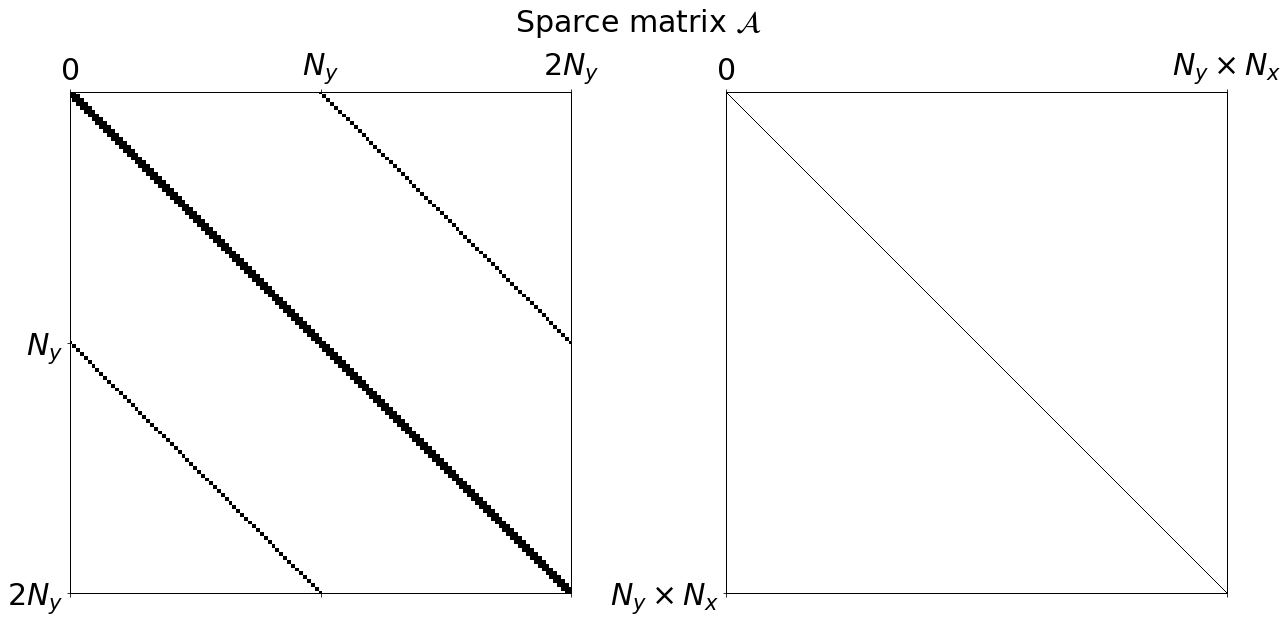

In [321]:
plt.clf()
fig, [ax, bx] = plt.subplots(figsize=(18,12), ncols=2)
ax.spy(A)
ax.set_xlim(0,2*N)
ax.set_xticks([0,N,2*N])
ax.set_xticklabels(["0",r"$N_y$",r"$2N_y$"], fontsize=30)
ax.set_ylim(2*N,0)
ax.set_yticks([2*N,N])
ax.set_yticklabels([r"$2N_y$",r"$N_y$"], fontsize=30)
#ax.set_xlim(2*N-10, 2*N+10)
#ax.set_ylim(2*N-10, 2*N+10)
set_transparency(fig, ax)
ax.set_aspect('equal')

bx.spy(A)
bx.set_xlim(0,N*2)
bx.set_xticks([0,N**2])
bx.set_xticklabels(["0",r"$N_y\times N_x$"], fontsize=30)
bx.set_ylim(N**2,0)
bx.set_yticks([N**2])
bx.set_yticklabels([r"$N_y\times N_x$"], fontsize=30)
set_transparency(fig, ax)
bx.set_aspect('equal')

fig.text(.4, .86, "Sparce matrix "+r"$\mathcal{A}$", fontsize=30)

fig.tight_layout()
plt.show()

In [327]:
R

array([[ 16.48079242,  16.41114352]])

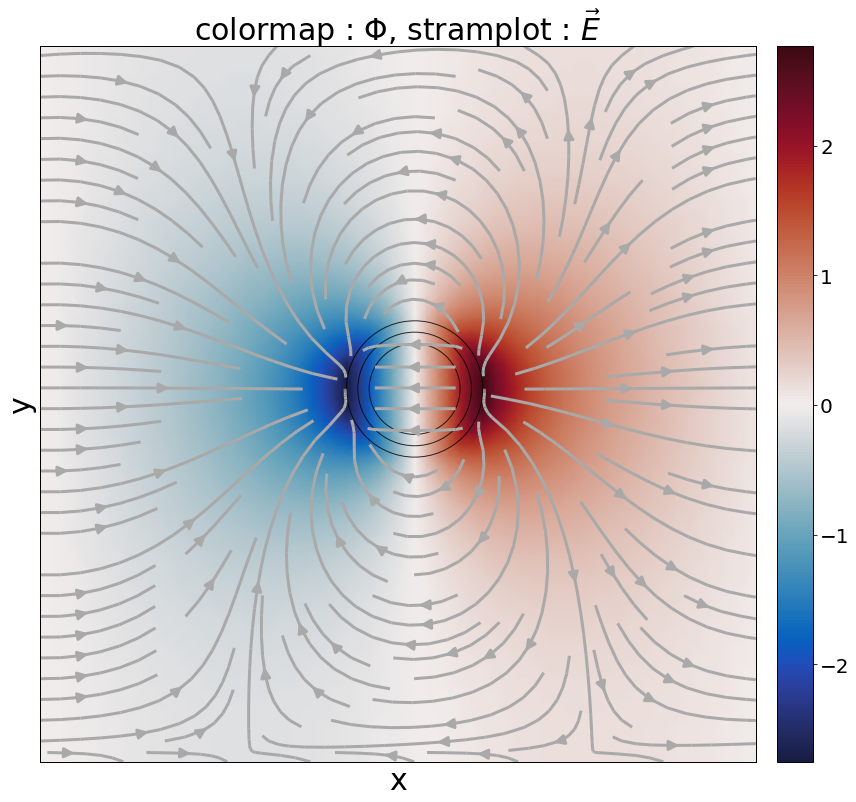

In [328]:
fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, potential,cmap=cmocean.cm.balance,shading='gouraud')
strm = ax.streamplot(x, y, np.transpose((E)[0]), np.transpose((E)[1]), linewidth=3, color='darkgrey', \
                                     cmap=cmocean.cm.balance, density=1.2, arrowsize=2)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title("colormap : "+r"$\Phi$"+", stramplot : "+r"$\vec{E}$", fontsize=30)

fig.tight_layout()
plt.show()

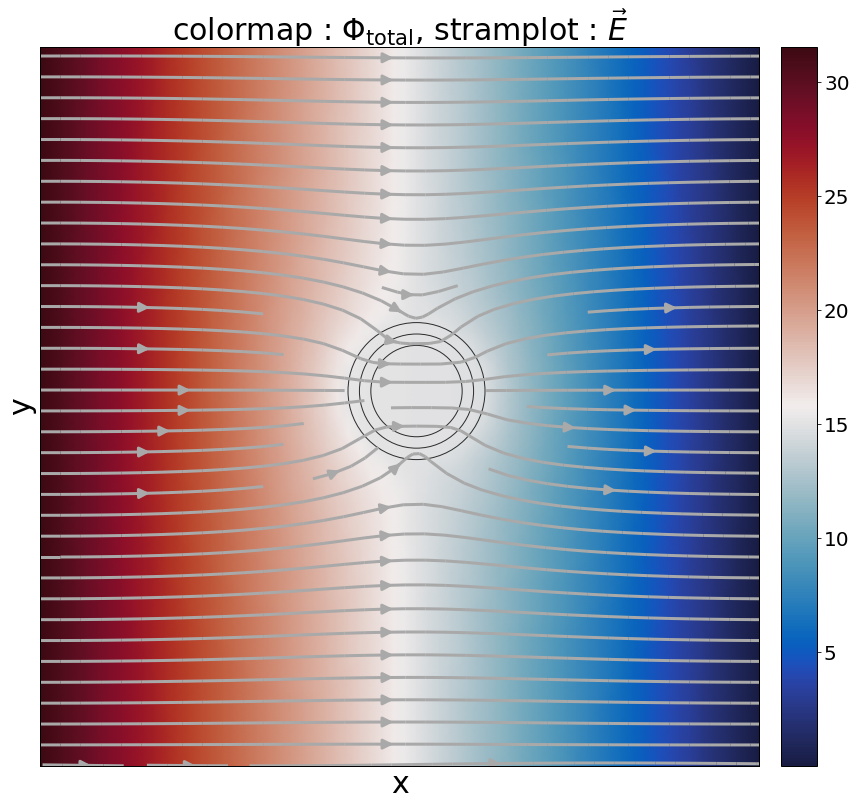

In [329]:
fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, potential+potential_ext,cmap=cmocean.cm.balance,shading='gouraud')
strm = ax.streamplot(x, y, np.transpose((E+Ext)[0]), np.transpose((E+Ext)[1]), linewidth=3, color='darkgrey', \
                                     cmap=cmocean.cm.balance, density=1.2, arrowsize=2)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title("colormap : "+r"$\Phi_{\rm total}$"+", stramplot : "+r"$\vec{E}$", fontsize=30)

fig.tight_layout()
plt.show()

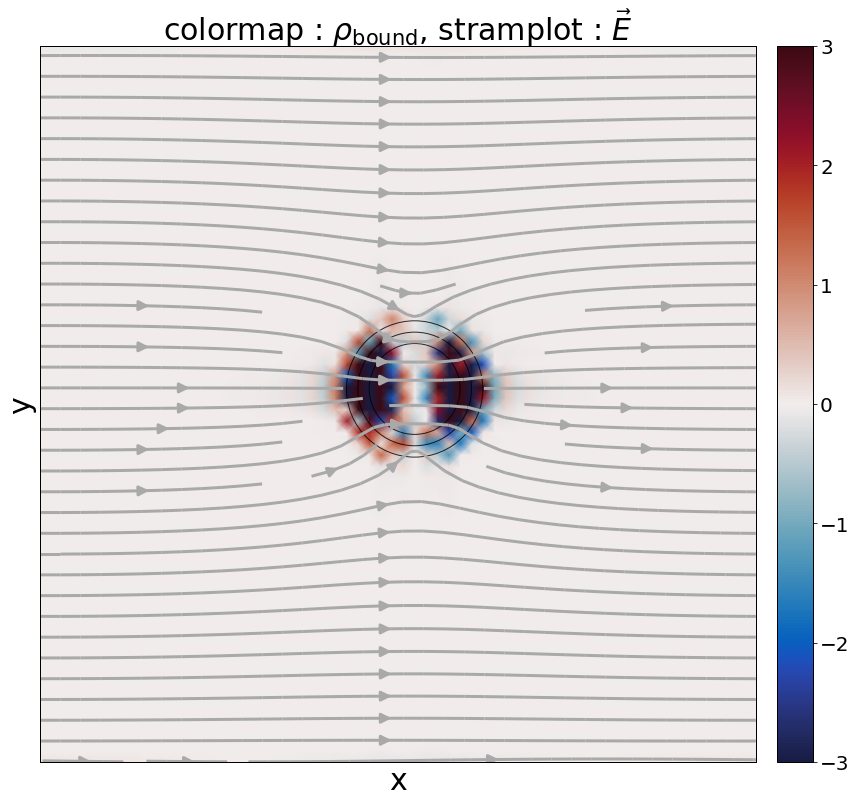

In [330]:
fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, rho_b,cmap=cmocean.cm.balance,shading='gouraud', vmax=3, vmin=-3)
strm = ax.streamplot(x, y, np.transpose((E+Ext)[0]), np.transpose((E+Ext)[1]), linewidth=3, color='darkgrey', \
                                     cmap=cmocean.cm.balance, density=1.2, arrowsize=2)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title("colormap : "+r"$\rho_{\rm bound}$"+", stramplot : "+r"$\vec{E}$", fontsize=30)

fig.tight_layout()
plt.show()

-----
# Result in c++

In [282]:
cpp = h5py.File('sample.h5', 'r')
potential_cpp = np.array(cpp['/field/potential'])
cpp.close()

In [314]:
def cutoff_E(pot):
    dmy = sys.ffta(potential_cpp)
    dmy[:11,:  ] = 0
    dmy[53:,:  ] = 0
    dmy[  :,22:] = 0
    return -sys.ifftu(1j*sys.grid.K*sys.grid.shiftK()*dmy)
# fourier transform
E_cpp       = -sys.ifftu(1j*sys.grid.K*sys.grid.shiftK()*sys.ffta(potential_cpp))
rho_b_cpp   = bound_charge_solver(E_cpp + Ext, 1)
E_cpp[...]  =  sys.grid.x2scalar(E_cpp[0]),sys.grid.y2scalar(E_cpp[1])

# finite deference
#E_cpp = -1/2/sys.grid.dx*np.stack([(np.roll(potential_cpp, -1, axis=i)-np.roll(potential_cpp, 1, axis=i)) for i in range(2)])
#rho_b_cpp = bound_charge_solver_fd(E_cpp + Ext, 1)

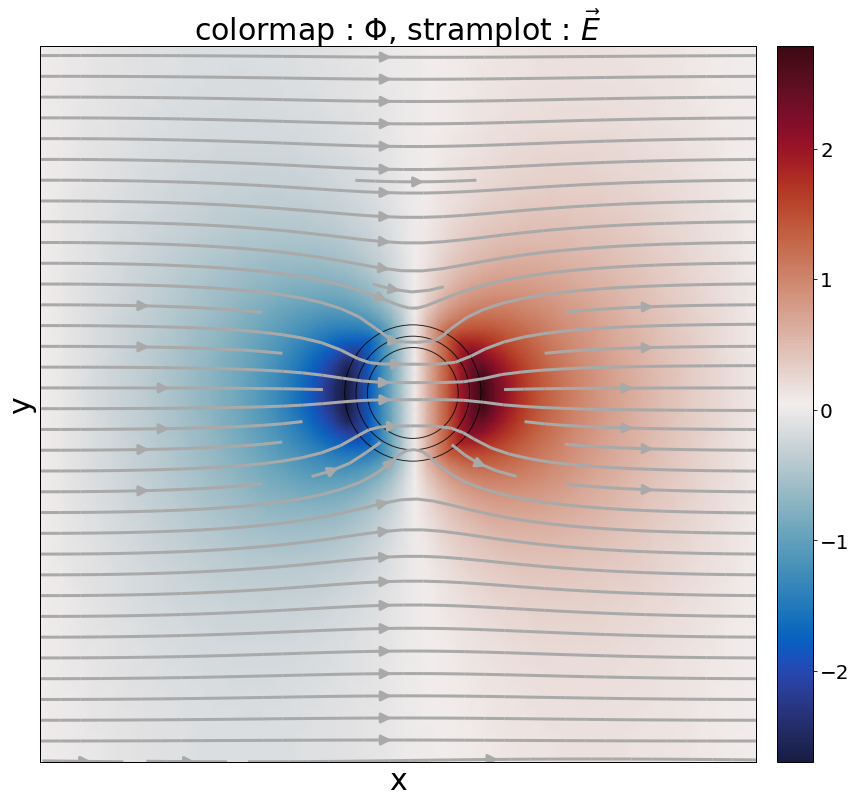

In [315]:
fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, potential_cpp,cmap=cmocean.cm.balance,shading='gouraud')
strm = ax.streamplot(x, y, np.transpose((E_cpp+Ext)[0]), np.transpose((E_cpp+Ext)[1]), linewidth=3, color='darkgrey', \
                                     cmap=cmocean.cm.balance, density=1.2, arrowsize=2)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title("colormap : "+r"$\Phi$"+", stramplot : "+r"$\vec{E}$", fontsize=30)

fig.tight_layout()
plt.show()

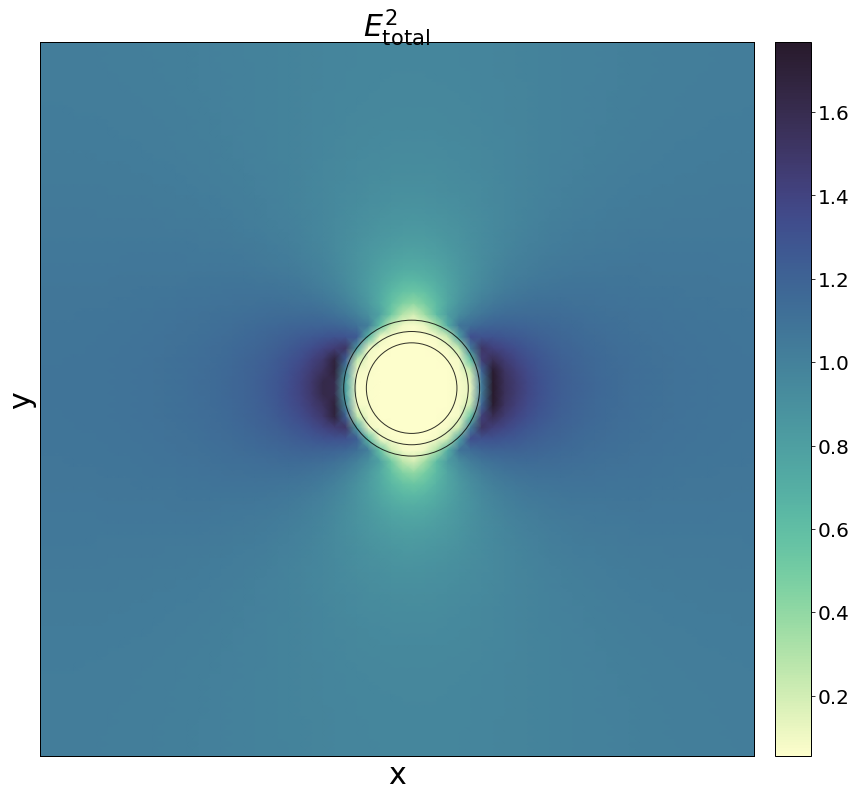

In [316]:
max_dmy = 2e-2

fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, np.linalg.norm(E_cpp+Ext, axis=0),cmap=cmocean.cm.deep,shading='gouraud')
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title(r"$E_{\rm total}^2$", fontsize=30)

fig.tight_layout()
plt.show()

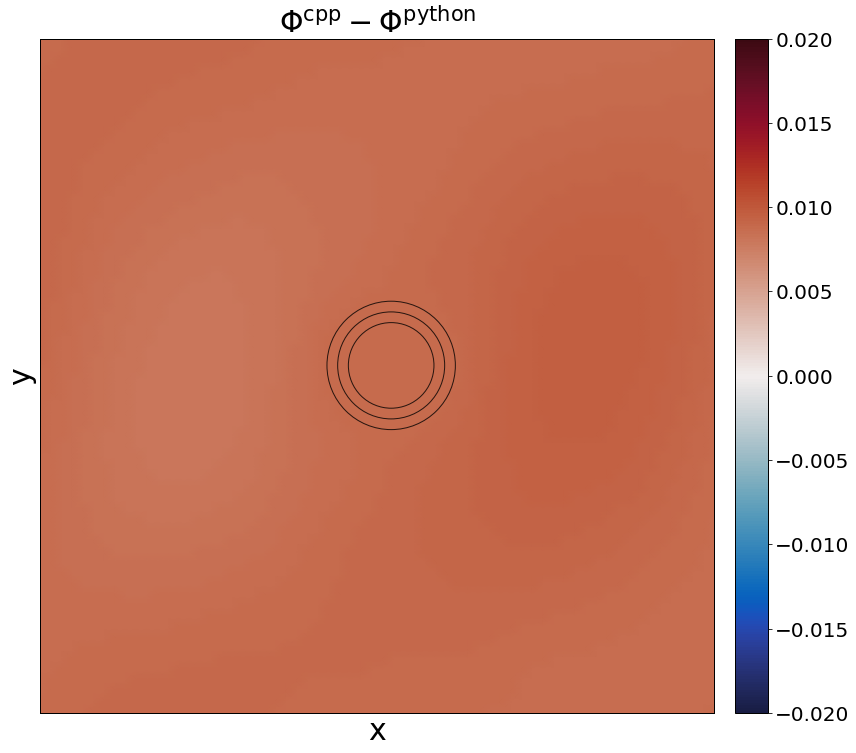

In [317]:
max_dmy = 2e-2

fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, potential_cpp-potential,cmap=cmocean.cm.balance,shading='gouraud', vmax=max_dmy, vmin=-max_dmy)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title(r"$\Phi^{\rm cpp}-\Phi^{\rm python}$", fontsize=30)

fig.tight_layout()
plt.show()

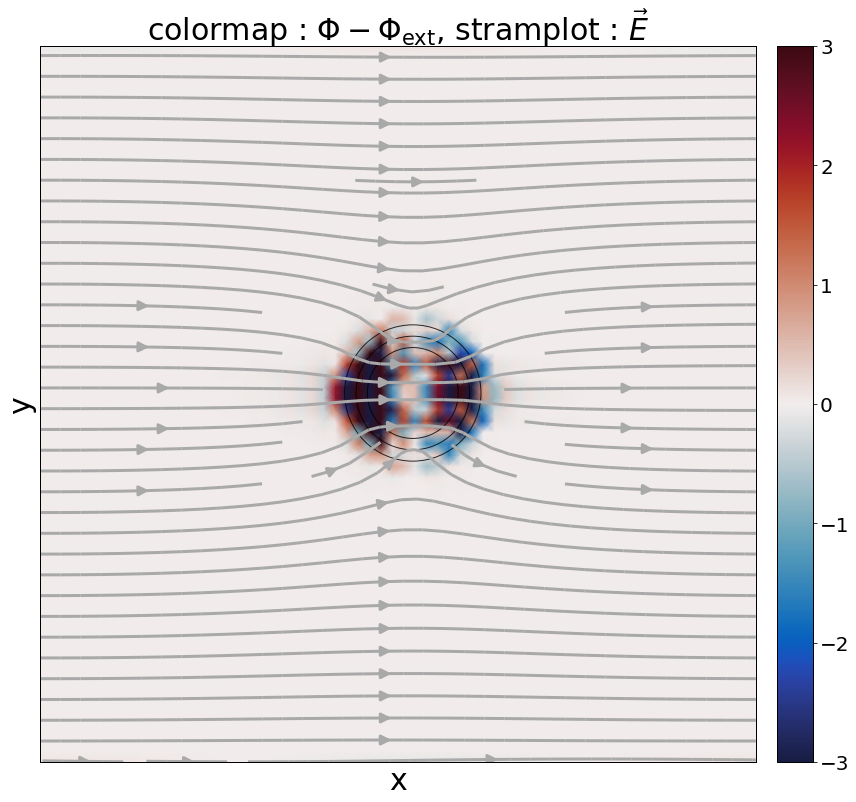

In [318]:
fig, ax = plt.subplots(figsize=(12,12))
im   = ax.pcolormesh(X, Y, rho_b_cpp,cmap=cmocean.cm.balance,shading='gouraud', vmax=3, vmin=-3)
strm = ax.streamplot(x, y, np.transpose((E_cpp+Ext)[0]), np.transpose((E_cpp+Ext)[1]), linewidth=3, color='darkgrey', \
                                     cmap=cmocean.cm.balance, density=1.2, arrowsize=2)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
set_colorbar(ax, im)
set_here(fig, ax)
ax.set_title("colormap : "+r"$\Phi-\Phi_{\rm ext}$"+", stramplot : "+r"$\vec{E}$", fontsize=30)

fig.tight_layout()
plt.show()

In [319]:
print("initial charge = 0")
print("sum(bound charge) = ", rho_b_cpp.sum())

initial charge = 0
sum(bound charge) =  7.1054273576e-15


-----
# Analysis

In [94]:
def computePotentialTheta(position, potential, coef_E=1):
    def particleGridDisplacement(Ri):
        return utils.distance(Ri[...,None,None], sys.grid.X, sys.grid.length[...,None,None])
    def particleGridDistance(Ri):
        return np.linalg.norm(particleGridDisplacement(Ri), axis=0)
    # calculate angle
    dR_vec = particleGridDisplacement(position)
    theta = np.arctan2(dR_vec[1], dR_vec[0]).astype(float)
    # calculate |r|
    dR = particleGridDistance(position)
    # analytical value for potential
    dmy_analytical = np.where(dR==0, 0, -coef_E*(dR-sys.particle.radius**2/dR)*np.cos(theta))
    dmy_analytical[dR<sys.particle.radius] = 0
    # remove except interface
    dR[dR>sys.particle.radius+sys.particle.xi/2] = 0
    dR[dR<sys.particle.radius-sys.particle.xi/2] = 0
    # reshape to 1D array
    NN = np.prod(potential.shape)
    dR = dR.reshape(NN)
    potential = potential.reshape(NN)
    theta = theta.reshape(NN)
    # remove except interface
    nonzero_dR = np.nonzero(dR)
    dmy_potential = potential[nonzero_dR]
    dmy_theta = theta[nonzero_dR]
    # shift from -pi~pi to 0~2pi
    dmy_index = dmy_theta<0
    dmy_theta[dmy_index] += 2*np.pi
    # fitting
    import scipy.optimize
    parameter_initial = np.array([0.0]) 
    def func(x, a):
        return a*np.cos(x-np.pi)
    paramater_optimal, covariance = scipy.optimize.curve_fit(func, dmy_theta, dmy_potential, p0=parameter_initial)
    dmy_fit = func(dmy_theta,paramater_optimal[0])
    return dmy_potential, dmy_theta, dmy_fit, paramater_optimal, dmy_analytical

In [95]:
potential_total     = potential     + potential_ext
potential_total_cpp = potential_cpp + potential_ext

angle_potential, angle, fitted_potential, fitting_parameter, potential_analytical = computePotentialTheta(R[0], potential)

numerical_potential     = potential_total     -(R[0,0]-sys.grid.dx)*coef_E
numerical_potential_cpp = potential_total_cpp -(R[0,0]-sys.grid.dx)*coef_E

/Users/oguri/anaconda/envs/spectralDNS_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


## c++

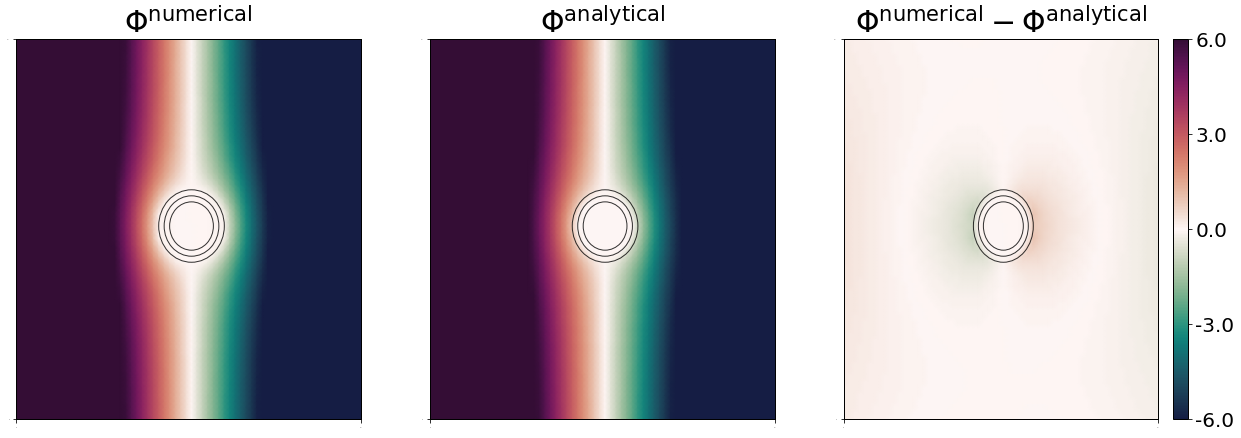

In [97]:
max_pot = 6
min_pot = -max_pot
lst_cbar = np.linspace(min_pot, max_pot, 5)

plt.clf()
plt.rcParams['axes.linewidth'] = 1
fig, [ax, bx, cx] = plt.subplots(figsize=(21,7),ncols=3)

im = ax.pcolormesh(X, Y, numerical_potential_cpp, cmap=cmocean.cm.curl,shading='gouraud', vmin=min_pot, vmax=max_pot)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
ax.set_xlim(0, sys.grid.length[0]-sys.grid.dx)
ax.set_xticks([0,sys.grid.length[0]-sys.grid.dx])
ax.set_xticklabels([0,sys.grid.length[0]-sys.grid.dx], fontsize=0)
ax.set_ylim(0, sys.grid.length[1]-sys.grid.dx)
ax.set_yticks([0,sys.grid.length[1]-sys.grid.dx])
ax.set_yticklabels([0,sys.grid.length[1]-sys.grid.dx], fontsize=0)
ax.set_title(r"$\Phi^{\rm numerical}$", fontsize=30)
    
im = bx.pcolormesh(X, Y, potential_analytical, cmap=cmocean.cm.curl,shading='gouraud', vmin=min_pot, vmax=max_pot)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    bx.add_artist(c)
bx.set_xlim(0, sys.grid.length[0]-sys.grid.dx)
bx.set_xticks([0,sys.grid.length[0]-sys.grid.dx])
bx.set_xticklabels([0,sys.grid.length[0]-sys.grid.dx], fontsize=0)
bx.set_ylim(0, sys.grid.length[1]-sys.grid.dx)
bx.set_yticks([0,sys.grid.length[1]-sys.grid.dx])
bx.set_yticklabels([0,sys.grid.length[1]-sys.grid.dx], fontsize=0)
bx.set_title(r"$\Phi^{\rm analytical}$", fontsize=30)

im = cx.pcolormesh(X, Y, numerical_potential_cpp-potential_analytical, cmap=cmocean.cm.curl,shading='gouraud', vmin=min_pot, vmax=max_pot)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    cx.add_artist(c)
cx.set_xlim(0, sys.grid.length[0]-sys.grid.dx)
cx.set_xticks([0,sys.grid.length[0]-sys.grid.dx])
cx.set_xticklabels([0,sys.grid.length[0]-sys.grid.dx], fontsize=0)
cx.set_ylim(0, sys.grid.length[1]-sys.grid.dx)
cx.set_yticks([0,sys.grid.length[1]-sys.grid.dx])
cx.set_yticklabels([0,sys.grid.length[1]-sys.grid.dx], fontsize=0)
cx.set_title(r"$\Phi^{\rm numerical}-\Phi^{\rm analytical}$", fontsize=30)

div = make_axes_locatable(cx)
cax = div.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=lst_cbar)
cbar.ax.set_yticklabels(lst_cbar, fontsize=20)

fig.patch.set_facecolor('white')  
fig.patch.set_alpha(0) 
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0) 
bx.patch.set_facecolor('white')
bx.patch.set_alpha(0) 
cx.patch.set_facecolor('white')
cx.patch.set_alpha(0) 

plt.show()

## python

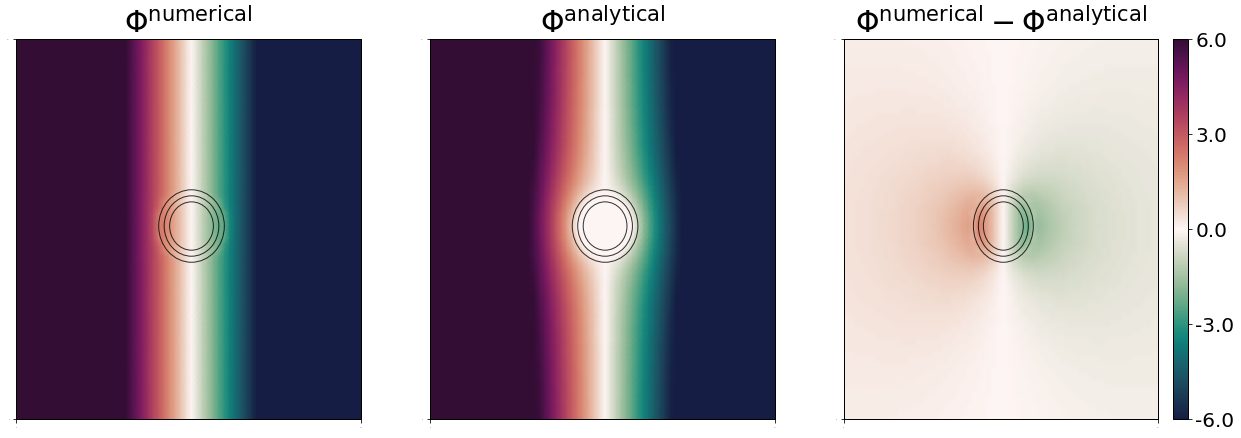

In [124]:
plt.clf()
plt.rcParams['axes.linewidth'] = 1
fig, [ax, bx, cx] = plt.subplots(figsize=(21,7),ncols=3)

im = ax.pcolormesh(X, Y, numerical_potential, cmap=cmocean.cm.curl,shading='gouraud', vmin=min_pot, vmax=max_pot)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    ax.add_artist(c)
ax.set_xlim(0, sys.grid.length[0]-sys.grid.dx)
ax.set_xticks([0,sys.grid.length[0]-sys.grid.dx])
ax.set_xticklabels([0,sys.grid.length[0]-sys.grid.dx], fontsize=0)
ax.set_ylim(0, sys.grid.length[1]-sys.grid.dx)
ax.set_yticks([0,sys.grid.length[1]-sys.grid.dx])
ax.set_yticklabels([0,sys.grid.length[1]-sys.grid.dx], fontsize=0)
ax.set_title(r"$\Phi^{\rm numerical}$", fontsize=30)
    
im = bx.pcolormesh(X, Y, potential_analytical, cmap=cmocean.cm.curl,shading='gouraud', vmin=min_pot, vmax=max_pot)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    bx.add_artist(c)
bx.set_xlim(0, sys.grid.length[0]-sys.grid.dx)
bx.set_xticks([0,sys.grid.length[0]-sys.grid.dx])
bx.set_xticklabels([0,sys.grid.length[0]-sys.grid.dx], fontsize=0)
bx.set_ylim(0, sys.grid.length[1]-sys.grid.dx)
bx.set_yticks([0,sys.grid.length[1]-sys.grid.dx])
bx.set_yticklabels([0,sys.grid.length[1]-sys.grid.dx], fontsize=0)
bx.set_title(r"$\Phi^{\rm analytical}$", fontsize=30)

im = cx.pcolormesh(X, Y, numerical_potential-potential_analytical, cmap=cmocean.cm.curl,shading='gouraud', vmin=min_pot, vmax=max_pot)
for da in [-sys.particle.xi/2, 0, sys.particle.xi/2]:
    c = plt.Circle((R[0,0], R[0,1]), sys.particle.radius + da, color='k', fill=False, lw=1, alpha=0.8)
    cx.add_artist(c)
cx.set_xlim(0, sys.grid.length[0]-sys.grid.dx)
cx.set_xticks([0,sys.grid.length[0]-sys.grid.dx])
cx.set_xticklabels([0,sys.grid.length[0]-sys.grid.dx], fontsize=0)
cx.set_ylim(0, sys.grid.length[1]-sys.grid.dx)
cx.set_yticks([0,sys.grid.length[1]-sys.grid.dx])
cx.set_yticklabels([0,sys.grid.length[1]-sys.grid.dx], fontsize=0)
cx.set_title(r"$\Phi^{\rm numerical}-\Phi^{\rm analytical}$", fontsize=30)

div = make_axes_locatable(cx)
cax = div.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=lst_cbar)
cbar.ax.set_yticklabels(lst_cbar, fontsize=20)

fig.patch.set_facecolor('white')  
fig.patch.set_alpha(0) 
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0) 
bx.patch.set_facecolor('white')
bx.patch.set_alpha(0) 
cx.patch.set_facecolor('white')
cx.patch.set_alpha(0) 

plt.show()